# Import Data

In [1]:
import numpy as np
import pandas as pd
import os
from dataloader import OCTDataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import os
import copy
import matplotlib.pyplot as plt


# Get path information
root = os.getcwd()
train = os.path.join(root, "df_prime_train.csv")
test = os.path.join(root, "df_prime_test.csv")


# Label Map
LABELS_SEVERITY = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


'''Obtain Dataset Images (image, label)'''


# experimentally determined mean and std for OCT images
mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

# transform matrix
transform2 = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize,
])

args = 'C:/Users/jgril/Documents/GitHub/8803_Final_Project'

# obtain train and test datasets
image_trainset = OCTDataset(args, 'train', transform=transform2)
image_testset = OCTDataset(args, 'test', transform=transform2)


# obtain flatten training images

images_train = []
labels_train = []

for i in range(len(image_trainset)):
    image,label = image_trainset.__getitem__(i)
    my_image = image.flatten().numpy()
    images_train.append(my_image)
    labels_train.append(label)


# obtain flatten test images

images_test = []
labels_test = []

for i in range(len(image_testset)):
    image,label = image_testset.__getitem__(i)
    my_image = image.flatten().numpy()
    images_test.append(my_image)
    labels_test.append(label)

print("Data loaded")


# convert to numpy array
images_train = np.array(images_train)
labels_train = np.array(labels_train)
images_test = np.array(images_test)
labels_test = np.array(labels_test)

loading data
data loaded


# KNN find best K value -- No PCA

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# Read dataset
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test


list_accuracies = []
list_balanced_accuracies = []
list_k = []

for i in range(1, 20):
    # Set number of neighbors
    k = i

    # Fit kNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict labels for testing set
    y_pred = knn.predict(X_test)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    print("Balanced_Accuracy:", balanced_accuracy)

    # Save results of each iteration
    list_accuracies.append(accuracy)
    list_balanced_accuracies.append(balanced_accuracy)
    list_k.append(i)




Accuracy: 0.38975835733066233
Balanced_Accuracy: 0.33813195253287415
Accuracy: 0.37711280831350946
Balanced_Accuracy: 0.32796753937306933
Accuracy: 0.3875046951295856
Balanced_Accuracy: 0.33585692341452705


Best K Value:  15
Balanced Accuracy:  0.33913927854020015


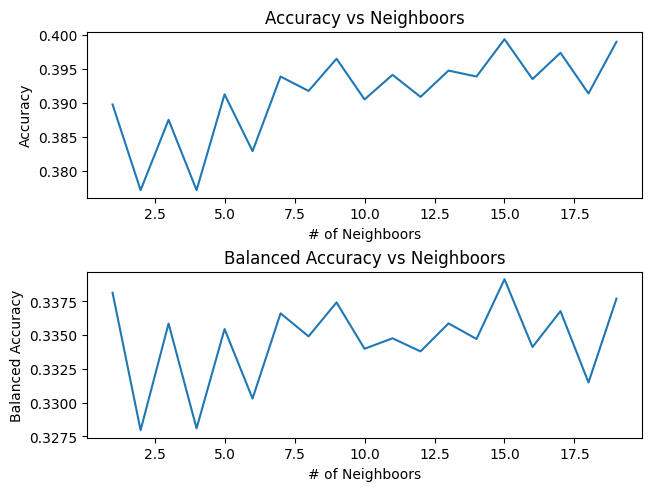

In [3]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout = 'constrained')

# Plot Accuracy vs K
ax1.plot(list_k, list_accuracies)
ax1.set_xlabel('# of Neighboors')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Neighboors')

# Plot Balanced Accuracy vs K
ax2.plot(list_k, list_balanced_accuracies)
ax2.set_xlabel('# of Neighboors')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_title('Balanced Accuracy vs Neighboors')

# Retrieve the best K value based on highest balanced accuracy
bestK = np.argmax(list_balanced_accuracies)
print("Best K Value: ", bestK + 1)
print("Balanced Accuracy: ", list_balanced_accuracies[bestK])

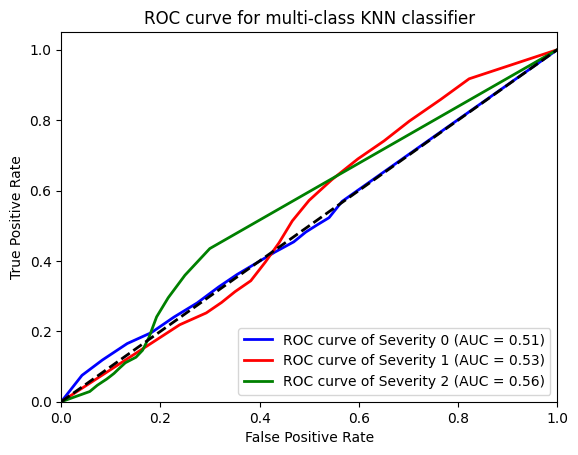

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

# Calculate the predicted probabilities of each class
y_pred_prob = knn.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute the ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of Severity %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class KNN classifier')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Metrics for recall, precision, and F1 score

from sklearn.metrics import f1_score, recall_score, precision_score
print("Recall: " + str(recall_score(y_test, y_pred, average = None)))
print("Precision: " + str(precision_score(y_test, y_pred, average = None, zero_division = 0)))

print("The F1 score for each class can be represented as such: ")
print(f1_score(y_test, y_pred, average=None))

Recall: [0.37755102 0.50306122 0.12574062]
Precision: [0.32743363 0.50460594 0.16739702]
The F1 score for each class can be represented as such: 
[0.3507109  0.5038324  0.14360902]


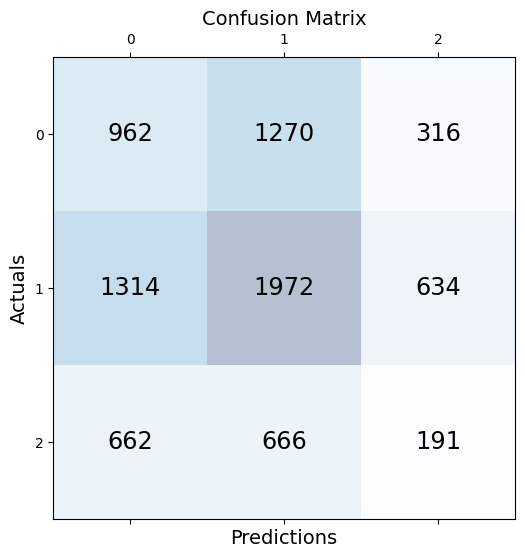

In [18]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Variance vs n PCA components

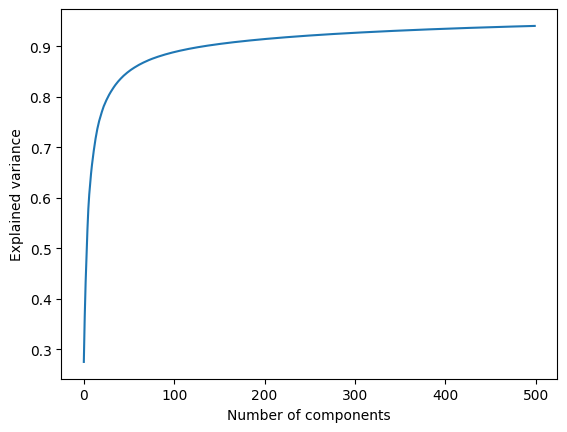

In [5]:
from sklearn.decomposition import PCA

# Split data
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test

#PCA for better feature condesnsing
pca_test = PCA(n_components=500)
pca_test.fit(X_train)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

## Best K for PCA n = 10, 20, 50, 100

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


# Read dataset
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test

# Holds balanced accuracies for each n components tested
list_balanced_accuracies_PCA_10 = []
list_balanced_accuracies_PCA_20 = []
list_balanced_accuracies_PCA_50 = []
list_balanced_accuracies_PCA_100 = []
list_k = []

n_PCA_components = [10, 20, 50, 100]


for j in n_PCA_components:
    # Preform PCA on the training data
    pca = PCA(n_components = j)
    train_PCA = pca.fit_transform(X_train)
    train_PCA = pca.inverse_transform(train_PCA)

    for i in range(1, 30):
        
        # Set number of neighbors
        k = i

        # Fit kNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_PCA, y_train)

        # Predict labels for testing set
        y_pred = knn.predict(X_test)

        # Calculate balanced accuracy score
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        print("Balanced_Accuracy:", balanced_accuracy)

        # Append values to respective lists
        if(j == 10):
            list_k.append(i)
            list_balanced_accuracies_PCA_10.append(balanced_accuracy)
        elif(j == 20):
            list_balanced_accuracies_PCA_20.append(balanced_accuracy)
        elif(j == 50):
            list_balanced_accuracies_PCA_50.append(balanced_accuracy)
        elif(j == 100):
            list_balanced_accuracies_PCA_100.append(balanced_accuracy)
        list_k.append(i)
        


Balanced_Accuracy: 0.3603944059013184
Balanced_Accuracy: 0.35274535372461635
Balanced_Accuracy: 0.3586150216910586
Balanced_Accuracy: 0.35180554852213836
Balanced_Accuracy: 0.35232566972198304
Balanced_Accuracy: 0.34856054084164684
Balanced_Accuracy: 0.34708500025320305
Balanced_Accuracy: 0.33724595297175947
Balanced_Accuracy: 0.34317681166759506
Balanced_Accuracy: 0.33766880201211996
Balanced_Accuracy: 0.3409823855100353
Balanced_Accuracy: 0.3385465724751439
Balanced_Accuracy: 0.33999826977937575
Balanced_Accuracy: 0.33745590047433366
Balanced_Accuracy: 0.3377302037440286
Balanced_Accuracy: 0.33678575648621734
Balanced_Accuracy: 0.3374316351850914
Balanced_Accuracy: 0.33250599247143026
Balanced_Accuracy: 0.33455883594132446
Balanced_Accuracy: 0.3298520028358738
Balanced_Accuracy: 0.3339551577454803
Balanced_Accuracy: 0.3290961918266066
Balanced_Accuracy: 0.3324697000388244
Balanced_Accuracy: 0.3275446903327088
Balanced_Accuracy: 0.3299452659475701
Balanced_Accuracy: 0.3272585709221654

In [ ]:
# Plot balanced accuracy vs k for each n 
plt.plot(list_k, list_balanced_accuracies_PCA_10, label='n=10', color ='r')
plt.plot(list_k, list_balanced_accuracies_PCA_20, label='n=20',color='g')
plt.plot(list_k, list_balanced_accuracies_PCA_50, label='n=50',color='b')
plt.plot(list_k, list_balanced_accuracies_PCA_100, label='n=100',color='yellow')

plt.xlabel('# of Neighboors')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Neighboors with PCA')
plt.legend()


bestK = np.argmax(list_balanced_accuracies_PCA_20)
print("Best K Value: ", bestK + 1)
print("Balanced Accuracy: ", list_balanced_accuracies_PCA_20[bestK])

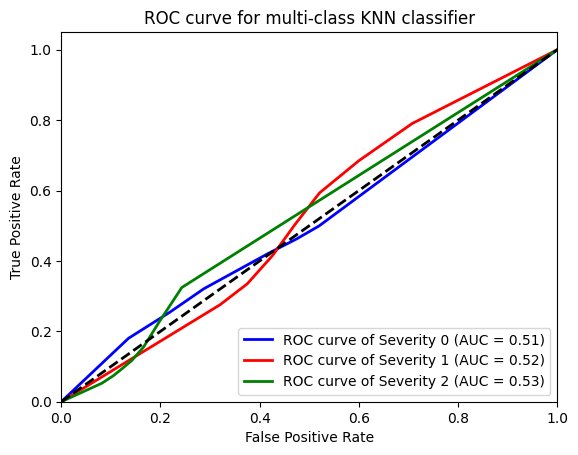

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

bestK = np.argmax(list_balanced_accuracies_PCA_20)
print("Best K Value: ", bestK + 1)
print("Balanced Accuracy: ", list_balanced_accuracies_PCA_20[bestK])

n_PCA_components = 20
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(X_train)
train_PCA = pca.inverse_transform(train_PCA)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Calculate the predicted probabilities of each class
y_pred_prob = knn.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute the ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of Severity %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Plot the chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class KNN classifier')
plt.legend(loc="lower right")
plt.show()

In [12]:
# metric for recall, precision, and F1 score

from sklearn.metrics import f1_score, recall_score, precision_score
print("Recall: " + str(recall_score(y_test, y_pred, average = None)))
print("Precision: " + str(precision_score(y_test, y_pred, average = None, zero_division = 0)))

print("The F1 score for each class can be represented as such: ")
print(f1_score(y_test, y_pred, average=None))

Recall: [0.36342229 0.54285714 0.10730744]
Precision: [0.32686198 0.52208047 0.15120594]
The F1 score for each class can be represented as such: 
[0.34417395 0.53226613 0.12552946]


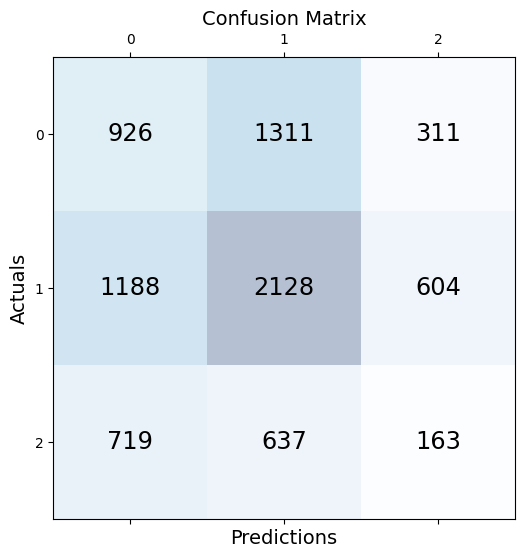

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# PCA Find Optimal n given K = 7

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Read dataset
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test


list_accuracies = []
list_balanced_accuracies = []
pca_list = []


for i in range(10, 300, 10):
    n_PCA_components = i
    pca = PCA(n_components=n_PCA_components)
    train_PCA = pca.fit_transform(X_train)
    #test_PCA = pca.transform(X_test)
    train_PCA = pca.inverse_transform(train_PCA)

    # Set number of neighbors
    k = 7

    # Fit kNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_PCA, y_train)

    # Predict labels for testing set
    y_pred = knn.predict(X_test)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    print("Balanced_Accuracy:", balanced_accuracy)

    list_accuracies.append(accuracy)
    list_balanced_accuracies.append(balanced_accuracy)
    pca_list.append(i)

    #this is so bad lmao maybe it'll get better when pca goes up? it is all good ??? what nothing it is supposed to be bad. Max people have gotten are like 50% with CNNs

Accuracy: 0.4145486415425066
Balanced_Accuracy: 0.347215821812596
Accuracy: 0.46675848253411795
Balanced_Accuracy: 0.39403179385898274
Accuracy: 0.43833729810942784
Balanced_Accuracy: 0.37186513563241674
Accuracy: 0.4102917240515838
Balanced_Accuracy: 0.34926824327745987
Accuracy: 0.4075372480280456
Balanced_Accuracy: 0.34538284296348815
Accuracy: 0.4064104169275072
Balanced_Accuracy: 0.34290567343562733
Accuracy: 0.40553399273819957
Balanced_Accuracy: 0.3425792525446903
Accuracy: 0.4057843996494303
Balanced_Accuracy: 0.3457151719248494
Accuracy: 0.40215349943658446
Balanced_Accuracy: 0.3447852838405834
Accuracy: 0.40265431325904594
Balanced_Accuracy: 0.34508849445485396
Accuracy: 0.3981469888568924
Balanced_Accuracy: 0.3415782566128189
Accuracy: 0.4009014648804307
Balanced_Accuracy: 0.34461584882091795
Accuracy: 0.40127707524727685
Balanced_Accuracy: 0.3445593001468577
Accuracy: 0.40353073744835355
Balanced_Accuracy: 0.3470824682230212
Accuracy: 0.40277951671466133
Balanced_Accuracy: 

Best PCA Components Values:  20
Accuracy:  0.46675848253411795
Balanced Accuracy:  0.39403179385898274


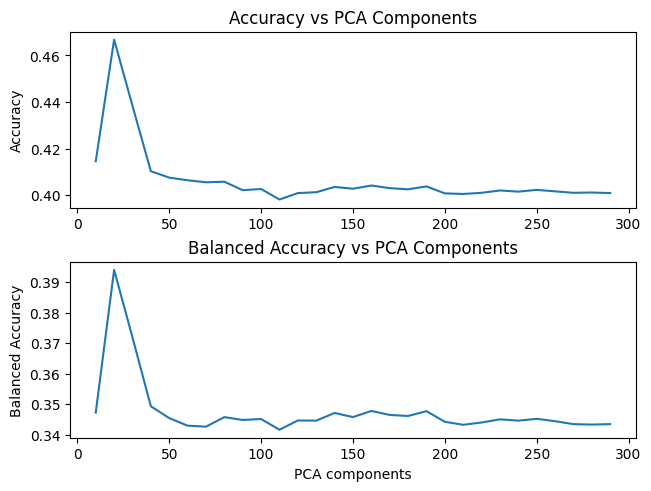

In [27]:
# Plot Balanced Accuracy vs PCA components

fig, [ax1, ax2] = plt.subplots(2, 1, layout = 'constrained')

ax1.plot(pca_list, list_accuracies)
ax2.set_xlabel('PCA components')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs PCA Components')

ax2.plot(pca_list, list_balanced_accuracies)
ax2.set_xlabel('PCA components')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_title('Balanced Accuracy vs PCA Components')

bestPCA = np.argmax(list_balanced_accuracies)
print("Best PCA Components Values: ", pca_list[bestPCA])
print("Accuracy: ", list_accuracies[bestPCA])
print("Balanced Accuracy: ", list_balanced_accuracies[bestPCA])


## Find Best K with PCA n = 100

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Read dataset
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test


list_accuracies = []
list_balanced_accuracies = []
list_k = []

n_PCA_components = 100
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(X_train)
test_PCA = pca.transform(X_test)
print(train_PCA.shape)


for i in range(1, 50):
    # Set number of neighbors
    k = i

    # Fit kNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_PCA, y_train)

    # Predict labels for testing set
    y_pred = knn.predict(test_PCA)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    print("Balanced_Accuracy:", balanced_accuracy)

    list_accuracies.append(accuracy)
    list_balanced_accuracies.append(balanced_accuracy)
    list_k.append(i)


(24252, 100)
Accuracy: 0.4042819581820458
Balanced_Accuracy: 0.350766783140055
Accuracy: 0.39313885063227744
Balanced_Accuracy: 0.34117228777367026
Accuracy: 0.40515838237135343
Balanced_Accuracy: 0.3507845073513276
Accuracy: 0.39414047827720045
Balanced_Accuracy: 0.34265753447781105
Accuracy: 0.40465756854889195
Balanced_Accuracy: 0.34807671207440793
Accuracy: 0.3943908851884312
Balanced_Accuracy: 0.33971552640907476
Accuracy: 0.40378114435958434
Balanced_Accuracy: 0.3463973430563292
Accuracy: 0.39714536121196947
Balanced_Accuracy: 0.34181816647254437
Accuracy: 0.4074120445724302
Balanced_Accuracy: 0.3480229064330447
Accuracy: 0.3980217854012771
Balanced_Accuracy: 0.34077982309549126
Accuracy: 0.40553399273819957
Balanced_Accuracy: 0.34414193717189107
Accuracy: 0.4024039063478152
Balanced_Accuracy: 0.3420544892895123
Accuracy: 0.4057843996494303
Balanced_Accuracy: 0.3432308283114735
Accuracy: 0.40365594090396895
Balanced_Accuracy: 0.34176604885130235
Accuracy: 0.4067860272943533
Balan

Best K Value:  3
Balanced Accuracy:  0.3507845073513276


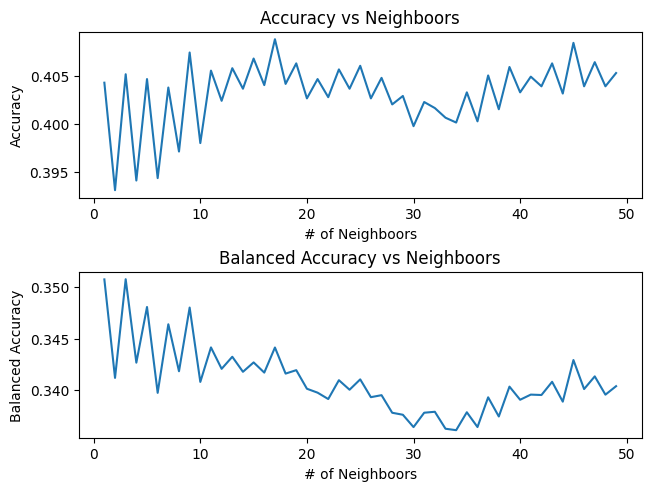

In [23]:
# Plot Balanced Accuracy vs PCA components

fig, [ax1, ax2] = plt.subplots(2, 1, layout = 'constrained')

ax1.plot(list_k, list_accuracies)
ax1.set_xlabel('# of Neighboors')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Neighboors')

ax2.plot(list_k, list_balanced_accuracies)
ax2.set_xlabel('# of Neighboors')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_title('Balanced Accuracy vs Neighboors')

bestK = np.argmax(list_balanced_accuracies)
print("Best K Value: ", bestK + 1)
print("Balanced Accuracy: ", list_balanced_accuracies[bestK])

In [25]:
# metric for recall, precision, and F1 score

from sklearn.metrics import f1_score, recall_score, precision_score
print("Recall: " + str(recall_score(y_test, y_pred, average = None)))
print("Precision: " + str(precision_score(y_test, y_pred, average = None, zero_division = 0)))

print("The F1 score for each class can be represented as such: ")
print(f1_score(y_test, y_pred, average=None))

Recall: [0.34379906 0.55484694 0.12244898]
Precision: [0.31935837 0.52333975 0.17095588]
The F1 score for each class can be represented as such: 
[0.33112833 0.53863299 0.14269275]


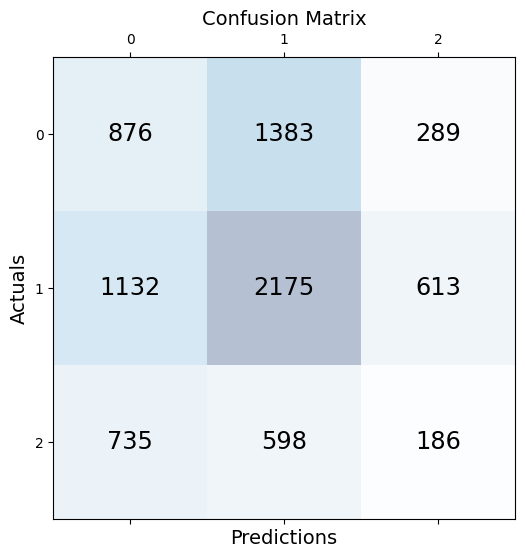

In [26]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## KNN find PCA componets given K = 3

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Read dataset
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test


list_accuracies = []
list_balanced_accuracies = []
pca_list = []


for i in range(10, 300, 10):
    n_PCA_components = i
    pca = PCA(n_components=n_PCA_components)
    train_PCA = pca.fit_transform(X_train)
    test_PCA = pca.transform(X_test)
    print(train_PCA.shape)

    # Set number of neighbors
    k = 3

    # Fit kNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_PCA, y_train)

    # Predict labels for testing set
    y_pred = knn.predict(test_PCA)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)
    print("Balanced_Accuracy:", balanced_accuracy)

    list_accuracies.append(accuracy)
    list_balanced_accuracies.append(balanced_accuracy)
    pca_list.append(i)

(24252, 10)
Accuracy: 0.4161762864655065
Balanced_Accuracy: 0.35180554852213836
(24252, 20)
Accuracy: 0.4577438337298109
Balanced_Accuracy: 0.39523387518779224
(24252, 30)
Accuracy: 0.4315763115061976
Balanced_Accuracy: 0.37303071352610523
(24252, 40)
Accuracy: 0.4057843996494303
Balanced_Accuracy: 0.3508921186340541
(24252, 50)
Accuracy: 0.4009014648804307
Balanced_Accuracy: 0.34498805725764253
(24252, 60)
Accuracy: 0.40277951671466133
Balanced_Accuracy: 0.34511887881703546
(24252, 70)
Accuracy: 0.39927381995743083
Balanced_Accuracy: 0.3419167046471194
(24252, 80)
Accuracy: 0.3987730061349693
Balanced_Accuracy: 0.3437581235968333
(24252, 90)
Accuracy: 0.39601853011143107
Balanced_Accuracy: 0.3437041069529549
(24252, 100)
Accuracy: 0.3937648679103543
Balanced_Accuracy: 0.3420390861059064
(24252, 110)
Accuracy: 0.3958933266558157
Balanced_Accuracy: 0.34483465842912847
(24252, 120)
Accuracy: 0.3927632402654313
Balanced_Accuracy: 0.342577353522054
(24252, 130)
Accuracy: 0.3923876298985852

Best PCA Components Values:  20
Accuracy:  0.4577438337298109
Balanced Accuracy:  0.39523387518779224


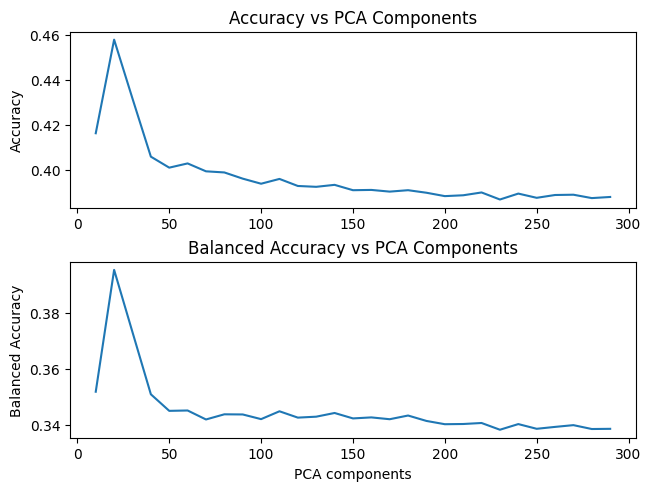

In [28]:
# Plot Balanced Accuracy vs PCA Components

fig, [ax1, ax2] = plt.subplots(2, 1, layout = 'constrained')

ax1.plot(pca_list, list_accuracies)
ax2.set_xlabel('PCA components')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs PCA Components')

ax2.plot(pca_list, list_balanced_accuracies)
ax2.set_xlabel('PCA components')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_title('Balanced Accuracy vs PCA Components')

bestPCA = np.argmax(list_balanced_accuracies)
print("Best PCA Components Values: ", pca_list[bestPCA])
print("Accuracy: ", list_accuracies[bestPCA])
print("Balanced Accuracy: ", list_balanced_accuracies[bestPCA])

In [30]:
# metric for recall, precision, and F1 score

from sklearn.metrics import f1_score, recall_score, precision_score
print("Recall: " + str(recall_score(y_test, y_pred, average = None)))
print("Precision: " + str(precision_score(y_test, y_pred, average = None, zero_division = 0)))

print("The F1 score for each class can be represented as such: ")
print(f1_score(y_test, y_pred, average=None))

Recall: [0.41601256 0.46938776 0.13034891]
Precision: [0.33887468 0.50054407 0.16737109]
The F1 score for each class can be represented as such: 
[0.37350247 0.48446551 0.14655811]


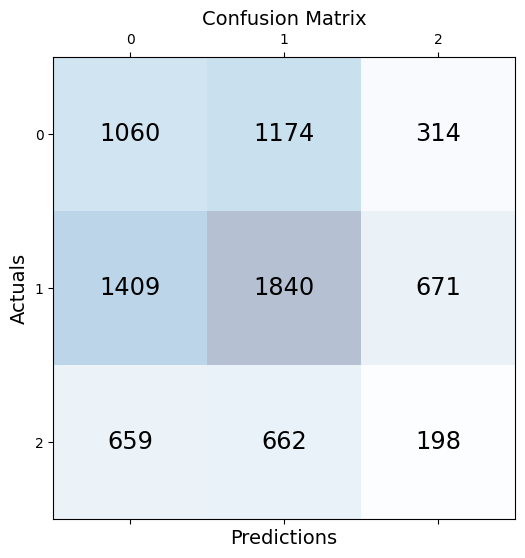

In [31]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()